# Dataset Preprocessing

### Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
from anndata import AnnData
import warnings
import yaml
import os
import warnings
import socket
import matplotlib as plt


warnings.filterwarnings('ignore')

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.22.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3
figure.dpi 50
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor white
dotSize 20


In [3]:
DSname="DownD250"
DSDirName="Sample_S20814_260"

### Configure paths

In [4]:

outdir = "../data/output"
if not os.path.exists(outdir):
   # Create a new directory because it does not exist
   os.makedirs(outdir)
    
if not os.path.exists("../data/output/adatas"):
   # Create a new directory because it does not exist
   os.makedirs("../data/output/adatas")

with open("../data/resources/iPSC_lines_map.yaml", 'r') as f:
    iPSC_lines_map = yaml.load(f, Loader=yaml.FullLoader)["lines"]
results_file = outdir+'/'+DSname+'.h5ad'

In [5]:
scanpyObj = sc.read_10x_mtx('../data/'+DSDirName+'/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

scanpyObj.obs['dataset'] = DSname
scanpyObj.obs_names = [i + "_" + j for i, j in zip(scanpyObj.obs_names.tolist(), scanpyObj.obs["dataset"].tolist())]

... reading from cache file cache/..-data-Sample_S20814_260-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
scanpyObj.var_names_make_unique()
scanpyObj.obs_names_make_unique()


### Importing cellIDs

In [7]:
cellID = pd.read_csv('../data/'+DSDirName+'/aggregatedCall/aggregatedCall.tsv', sep ="\t",index_col = 0)
cellID
cellID.index = [i + "_" + DSname for i in cellID.index.tolist()]

In [8]:
cellID.Consensus.unique()

array(['MIFF1', '3391B', 'CROLE', 'A15441', 'DESTa', 'KOLF', 'doublet',
       'LowQuality'], dtype=object)

In [9]:
scanpyObj.obs['cellID'] = cellID.loc[scanpyObj.obs_names, 'Consensus']


In [10]:
scanpyObj.obs

,dataset,cellID
AAACCTGAGACAAAGG-1_DownD250,DownD250,doublet
AAACCTGAGAGACTAT-1_DownD250,DownD250,MIFF1
AAACCTGAGCCACTAT-1_DownD250,DownD250,3391B
AAACCTGAGTGTCCAT-1_DownD250,DownD250,CROLE
AAACCTGAGTTATCGC-1_DownD250,DownD250,A15441
...,...,...
TTTGTCAGTCCAAGTT-1_DownD250,DownD250,doublet
TTTGTCAGTCGTTGTA-1_DownD250,DownD250,A15441
TTTGTCAGTGATGCCC-1_DownD250,DownD250,LowQuality
TTTGTCAGTGCACGAA-1_DownD250,DownD250,3391B


### Configure colors

In [11]:
cellID_colors = {}
cellID_newName_colors = {}
cellID_newNames = {}


for line in iPSC_lines_map.keys():
    cellID_colors[iPSC_lines_map[line]["oldName"]] = iPSC_lines_map[line]["color"]
    cellID_newName_colors[iPSC_lines_map[line]["newName"]] = iPSC_lines_map[line]["color"]
    cellID_newNames[iPSC_lines_map[line]["oldName"]] = iPSC_lines_map[line]["newName"]

scanpyObj.obs["cellID"] = scanpyObj.obs["cellID"].astype("category")
scanpyObj.obs["cellID_newName"] = scanpyObj.obs["cellID"].replace(cellID_newNames, inplace=False).astype("category")
scanpyObj.uns["cellID_colors"] = [cellID_colors[line] for line in scanpyObj.obs["cellID"].cat.categories]
scanpyObj.uns["cellID_newName_colors"] = [cellID_newName_colors[line] for line in scanpyObj.obs["cellID_newName"].cat.categories]

In [12]:
[cellID_colors[line] for line in scanpyObj.obs["cellID"].cat.categories]

['#DBB807',
 '#64f5d9',
 '#006666',
 '#FF00CC',
 '#0FB248',
 '#a8a5a5',
 '#7B00FF',
 '#403b3b']

### Preprocessing 

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


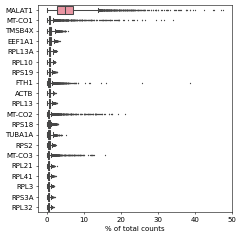

In [13]:
sc.pl.highest_expr_genes(scanpyObj, n_top=20 )

### Subsetting according to good barcodes

In [14]:
goodBarcodes=pd.read_csv(outdir+'/'+DSname+'_filteredCells.tsv', sep="\t")["BCs"]+"_"+DSname
scanpyObj = scanpyObj[goodBarcodes,:]



### QC metrices

In [15]:
scanpyObj.var['mt'] = scanpyObj.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scanpyObj, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

scanpyObj.var['ribo'] = scanpyObj.var_names.str.startswith('RP')  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(scanpyObj, qc_vars=['ribo'], percent_top=None, log1p=True, inplace=True)

In [16]:
scanpyObj

AnnData object with n_obs × n_vars = 3035 × 33538
    obs: 'dataset', 'cellID', 'cellID_newName', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo'
    uns: 'cellID_colors', 'cellID_newName_colors'

In [17]:
scanpyObj.var

,gene_ids,feature_types,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,ribo
MIR1302-2HG,ENSG00000243485,Gene Expression,False,1,0.000329,0.000329,99.967051,1.0,0.693147,False
FAM138A,ENSG00000237613,Gene Expression,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False
OR4F5,ENSG00000186092,Gene Expression,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False
AL627309.1,ENSG00000238009,Gene Expression,False,6,0.001977,0.001975,99.802306,6.0,1.945910,False
AL627309.3,ENSG00000239945,Gene Expression,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False
...,...,...,...,...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False
AC233755.1,ENSG00000275063,Gene Expression,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False
AC240274.1,ENSG00000271254,Gene Expression,False,134,0.047117,0.046041,95.584843,143.0,4.969813,False
AC213203.1,ENSG00000277475,Gene Expression,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False


In [18]:
scanpyObj.obs

,dataset,cellID,cellID_newName,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo
AAACCTGAGAGACTAT-1_DownD250,DownD250,MIFF1,CTL02A,2586,7.858254,6358.0,8.757627,175.0,5.170484,2.752438,1071.0,6.977282,16.844919
AAACCTGCATGGTTGT-1_DownD250,DownD250,KOLF,CTL08A,1372,7.224753,2540.0,7.840313,73.0,4.304065,2.874016,349.0,5.857933,13.740158
AAACCTGTCAGTTAGC-1_DownD250,DownD250,3391B,CTL01,1216,7.104144,2859.0,7.958577,43.0,3.784190,1.504022,713.0,6.570883,24.938791
AAACGGGCAGATCGGA-1_DownD250,DownD250,3391B,CTL01,2043,7.622664,5681.0,8.645059,107.0,4.682131,1.883471,1692.0,7.434258,29.783491
AAACGGGCAGCTATTG-1_DownD250,DownD250,MIFF1,CTL02A,1682,7.428333,3906.0,8.270525,117.0,4.770685,2.995392,1089.0,6.993933,27.880182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTGGCTCCA-1_DownD250,DownD250,MIFF1,CTL02A,1277,7.153052,2764.0,7.924796,25.0,3.258096,0.904486,651.0,6.480044,23.552822
TTTGGTTGTTCGGCAC-1_DownD250,DownD250,MIFF1,CTL02A,898,6.801283,1394.0,7.240650,33.0,3.526361,2.367288,150.0,5.017280,10.760402
TTTGGTTTCAAGGCTT-1_DownD250,DownD250,KOLF,CTL08A,2006,7.604396,5483.0,8.609591,239.0,5.480639,4.358928,1246.0,7.128496,22.724787
TTTGTCACAGATGGGT-1_DownD250,DownD250,KOLF,CTL08A,1609,7.383989,4091.0,8.316789,138.0,4.934474,3.373258,1103.0,7.006695,26.961622


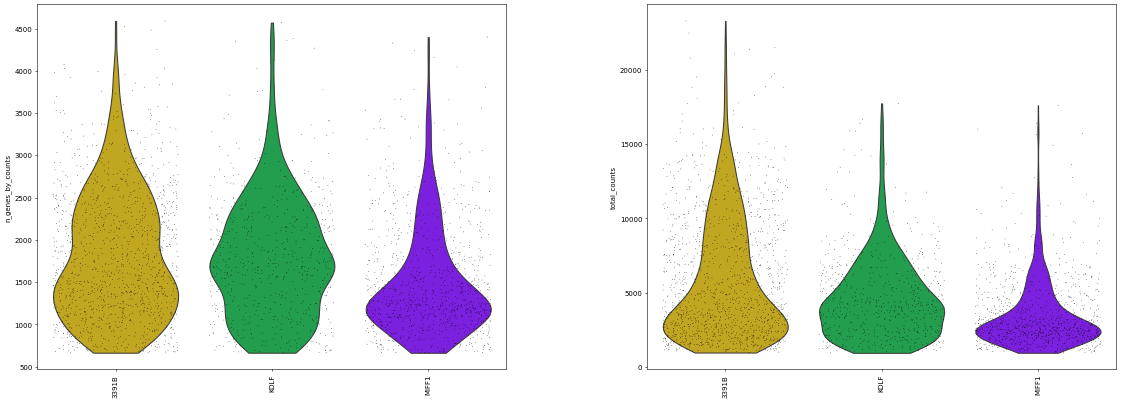

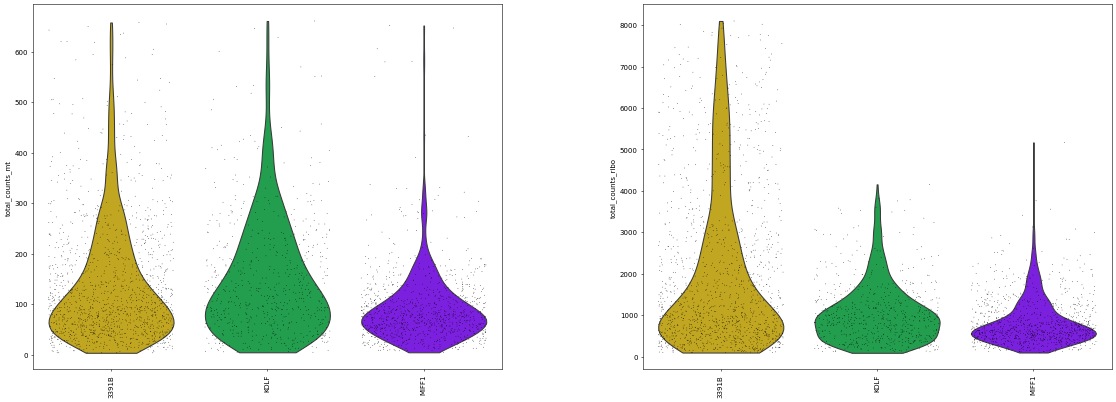

In [19]:
sc.pl.violin(scanpyObj, ['n_genes_by_counts', 'total_counts'],
             groupby= "cellID", jitter=0.4, multi_panel=True, rotation=90)

sc.pl.violin(scanpyObj, ['total_counts_mt','total_counts_ribo'],
             groupby= "cellID", jitter=0.4, multi_panel=True, rotation=90)

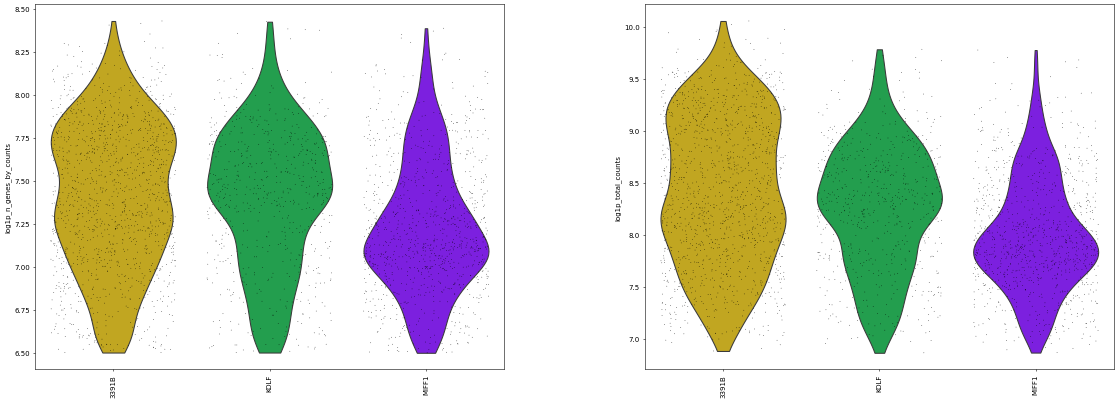

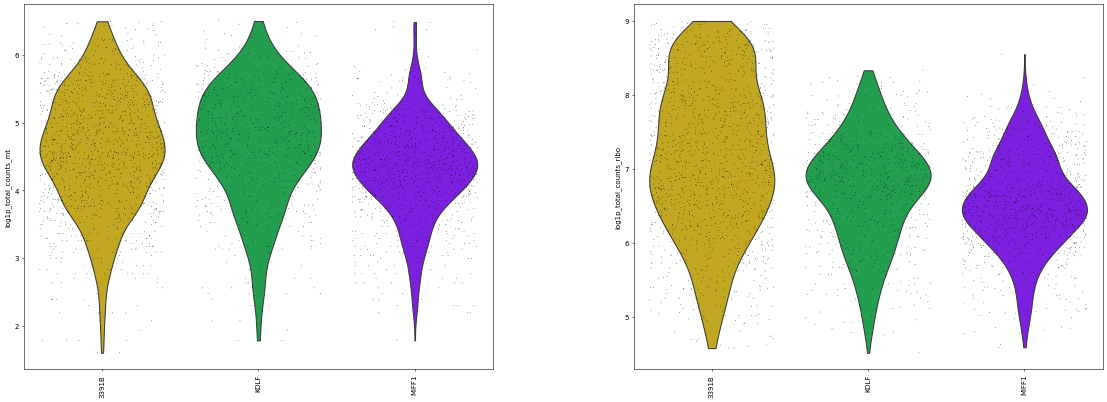

In [20]:
sc.pl.violin(scanpyObj, ['log1p_n_genes_by_counts', 'log1p_total_counts'],
             groupby= "cellID", jitter=0.4, multi_panel=True, rotation=90)

sc.pl.violin(scanpyObj, ['log1p_total_counts_mt','log1p_total_counts_ribo'],
             groupby= "cellID", jitter=0.4, multi_panel=True, rotation=90)

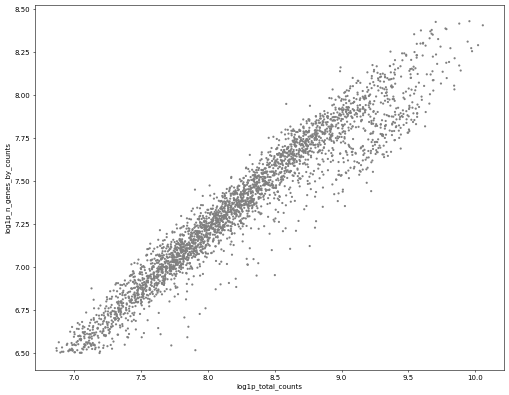

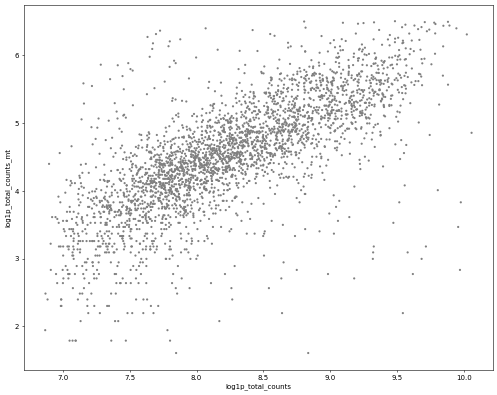

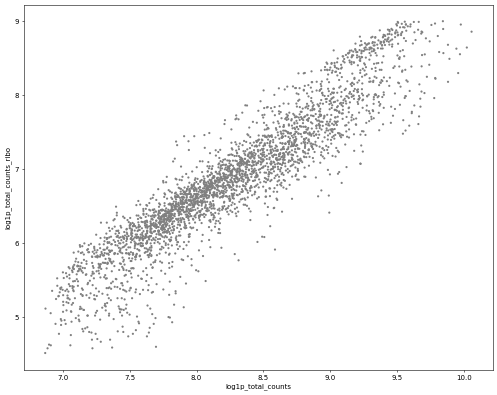

In [21]:
sc.pl.scatter(scanpyObj, x='log1p_total_counts', y='log1p_n_genes_by_counts')
sc.pl.scatter(scanpyObj, x='log1p_total_counts', y='log1p_total_counts_mt')
sc.pl.scatter(scanpyObj, x='log1p_total_counts', y='log1p_total_counts_ribo')

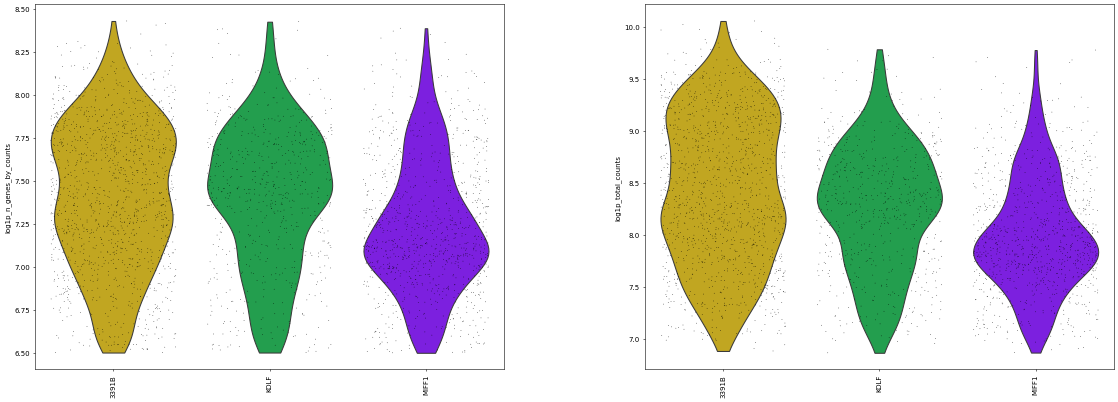

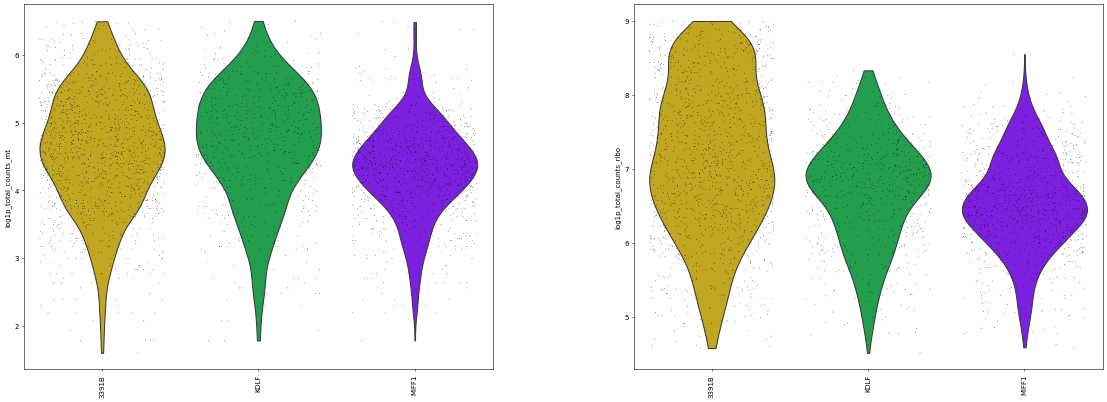

In [22]:
sc.pl.violin(scanpyObj, ['log1p_n_genes_by_counts', 'log1p_total_counts'],
             groupby= "cellID", jitter=0.4, multi_panel=True, rotation=90)

sc.pl.violin(scanpyObj, ['log1p_total_counts_mt','log1p_total_counts_ribo'],
             groupby= "cellID", jitter=0.4, multi_panel=True, rotation=90)

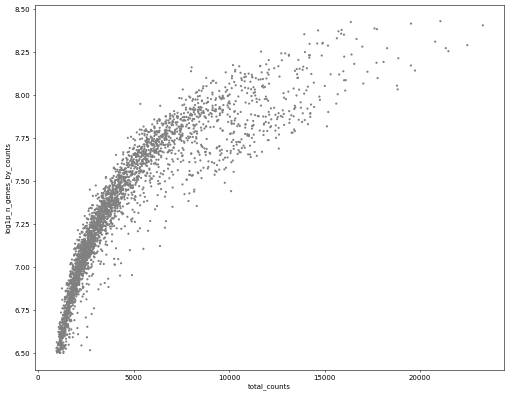

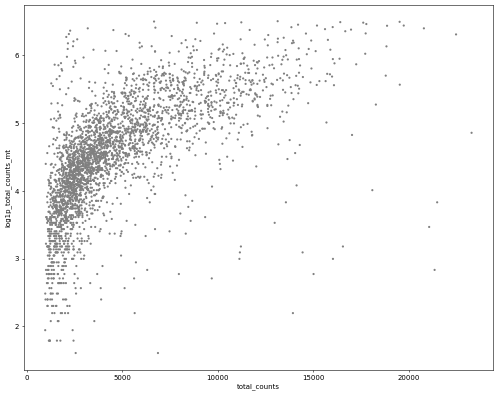

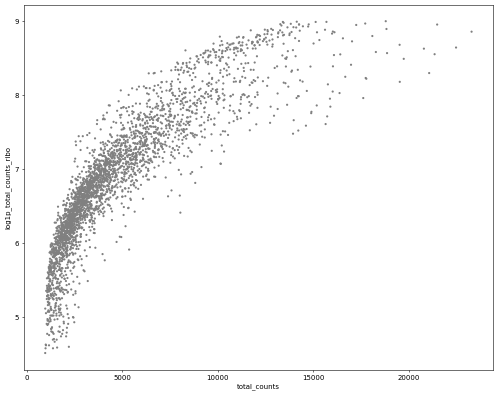

In [23]:
sc.pl.scatter(scanpyObj, x='total_counts', y='log1p_n_genes_by_counts')
sc.pl.scatter(scanpyObj, x='total_counts', y='log1p_total_counts_mt')
sc.pl.scatter(scanpyObj, x='total_counts', y='log1p_total_counts_ribo')

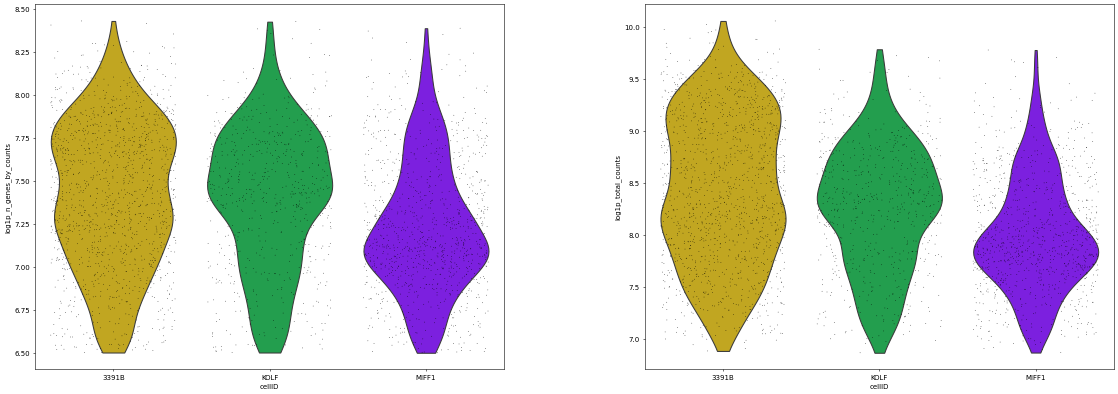

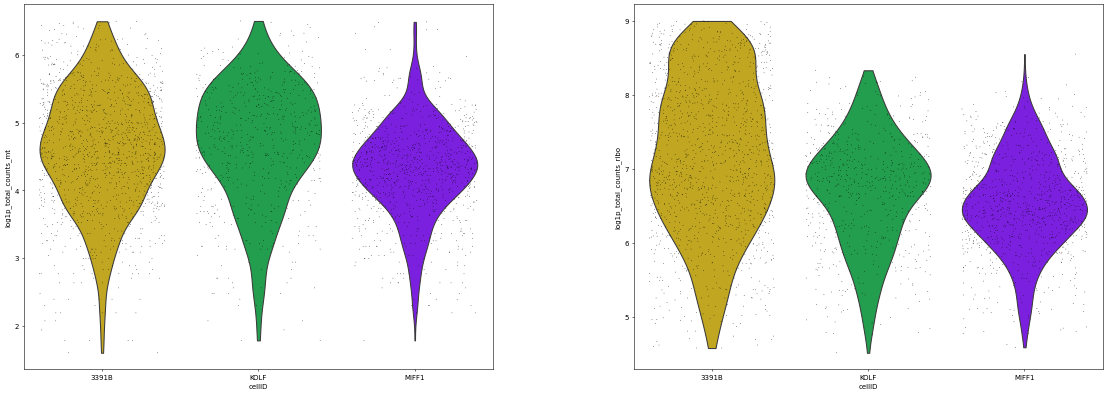

In [24]:
sc.pl.violin(scanpyObj, ['log1p_n_genes_by_counts', 'log1p_total_counts'],
             groupby= "cellID", jitter=0.4, multi_panel=True)

sc.pl.violin(scanpyObj, ['log1p_total_counts_mt','log1p_total_counts_ribo'],
             groupby= "cellID", jitter=0.4, multi_panel=True)

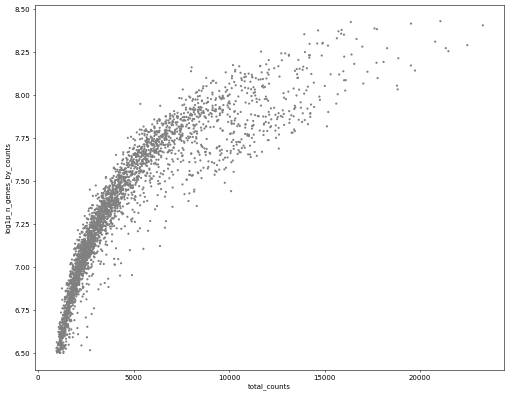

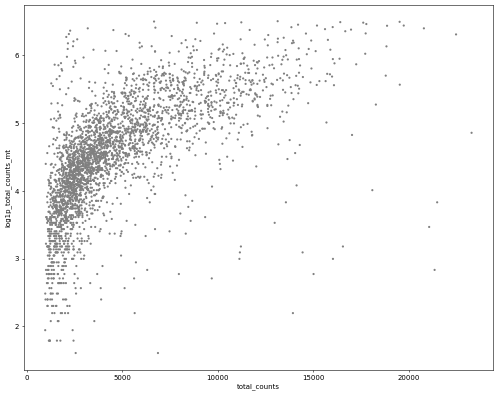

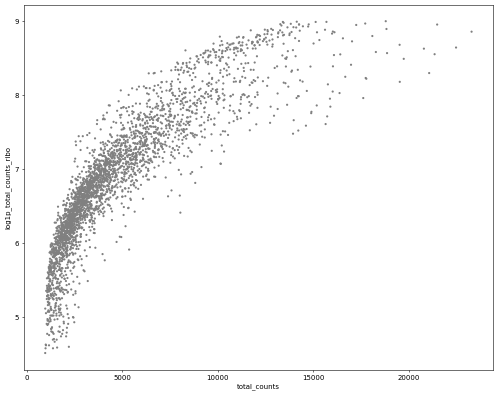

In [25]:
sc.pl.scatter(scanpyObj, x='total_counts', y='log1p_n_genes_by_counts')
sc.pl.scatter(scanpyObj, x='total_counts', y='log1p_total_counts_mt')
sc.pl.scatter(scanpyObj, x='total_counts', y='log1p_total_counts_ribo')

In [26]:
scanpyObj.write_h5ad(outdir+'/adatas/'+DSname+'_raw.h5ad')

In [27]:
sc.pp.normalize_total(scanpyObj, exclude_highly_expressed=True, max_fraction=.1)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['MALAT1', 'TTR', 'MT-CO1']
    finished (0:00:00)


In [28]:
sc.pp.log1p(scanpyObj)

In [29]:
scanpyObj.raw = scanpyObj


### Subset according to JointHVGs and Filtered Barcodes from previous step

In [30]:
HVGs=pd.read_csv(outdir+"/HVG_list_intersection_Curated.txt", sep = "\t")["HVG"]

scanpyObj = scanpyObj[:,HVGs]
scanpyObj.var["highly_variable"] = True

In [31]:
#sc.pp.highly_variable_genes(scanpyObj, min_mean=0.0125, max_mean=5, min_disp=0.5)

In [32]:
#scanpyObj = scanpyObj[:, HVG.tolist()]

#Multiplexing = Multiplexing[:, Multiplexing.var.highly_variable]

In [33]:
#sc.pl.highly_variable_genes(scanpyObj)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [34]:
sc.pp.regress_out(scanpyObj, ['total_counts',"pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [35]:
sc.pp.scale(scanpyObj, max_value=20)

In [36]:
scanpyObj.obs

,dataset,cellID,cellID_newName,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo
AAACCTGAGAGACTAT-1_DownD250,DownD250,MIFF1,CTL02A,2586,7.858254,6358.0,8.757627,175.0,5.170484,2.752438,1071.0,6.977282,16.844919
AAACCTGCATGGTTGT-1_DownD250,DownD250,KOLF,CTL08A,1372,7.224753,2540.0,7.840313,73.0,4.304065,2.874016,349.0,5.857933,13.740158
AAACCTGTCAGTTAGC-1_DownD250,DownD250,3391B,CTL01,1216,7.104144,2859.0,7.958577,43.0,3.784190,1.504022,713.0,6.570883,24.938791
AAACGGGCAGATCGGA-1_DownD250,DownD250,3391B,CTL01,2043,7.622664,5681.0,8.645059,107.0,4.682131,1.883471,1692.0,7.434258,29.783491
AAACGGGCAGCTATTG-1_DownD250,DownD250,MIFF1,CTL02A,1682,7.428333,3906.0,8.270525,117.0,4.770685,2.995392,1089.0,6.993933,27.880182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTGGCTCCA-1_DownD250,DownD250,MIFF1,CTL02A,1277,7.153052,2764.0,7.924796,25.0,3.258096,0.904486,651.0,6.480044,23.552822
TTTGGTTGTTCGGCAC-1_DownD250,DownD250,MIFF1,CTL02A,898,6.801283,1394.0,7.240650,33.0,3.526361,2.367288,150.0,5.017280,10.760402
TTTGGTTTCAAGGCTT-1_DownD250,DownD250,KOLF,CTL08A,2006,7.604396,5483.0,8.609591,239.0,5.480639,4.358928,1246.0,7.128496,22.724787
TTTGTCACAGATGGGT-1_DownD250,DownD250,KOLF,CTL08A,1609,7.383989,4091.0,8.316789,138.0,4.934474,3.373258,1103.0,7.006695,26.961622


### Principal component analysis

In [37]:
sc.tl.pca(scanpyObj, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


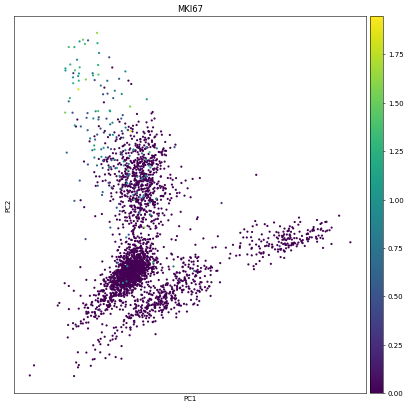

In [38]:
sc.pl.pca(scanpyObj, color='MKI67')

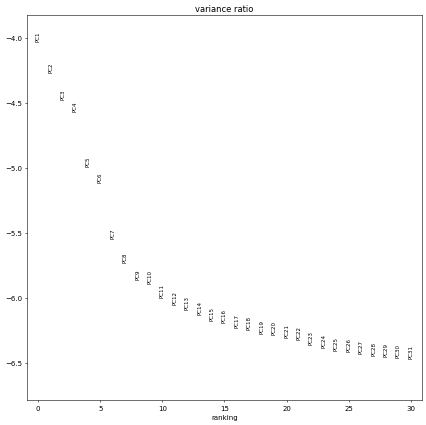

In [39]:
sc.pl.pca_variance_ratio(scanpyObj, log=True)

In [40]:
scanpyObj

AnnData object with n_obs × n_vars = 3035 × 3499
    obs: 'dataset', 'cellID', 'cellID_newName', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'highly_variable', 'mean', 'std'
    uns: 'cellID_colors', 'cellID_newName_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Computing the neighborhood graph

In [41]:
sc.pp.neighbors(scanpyObj, n_neighbors=10, n_pcs=9)

computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


### Embedding the neighborhood graph

In [42]:
sc.tl.umap(scanpyObj)
scanpyObj

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


AnnData object with n_obs × n_vars = 3035 × 3499
    obs: 'dataset', 'cellID', 'cellID_newName', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'highly_variable', 'mean', 'std'
    uns: 'cellID_colors', 'cellID_newName_colors', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

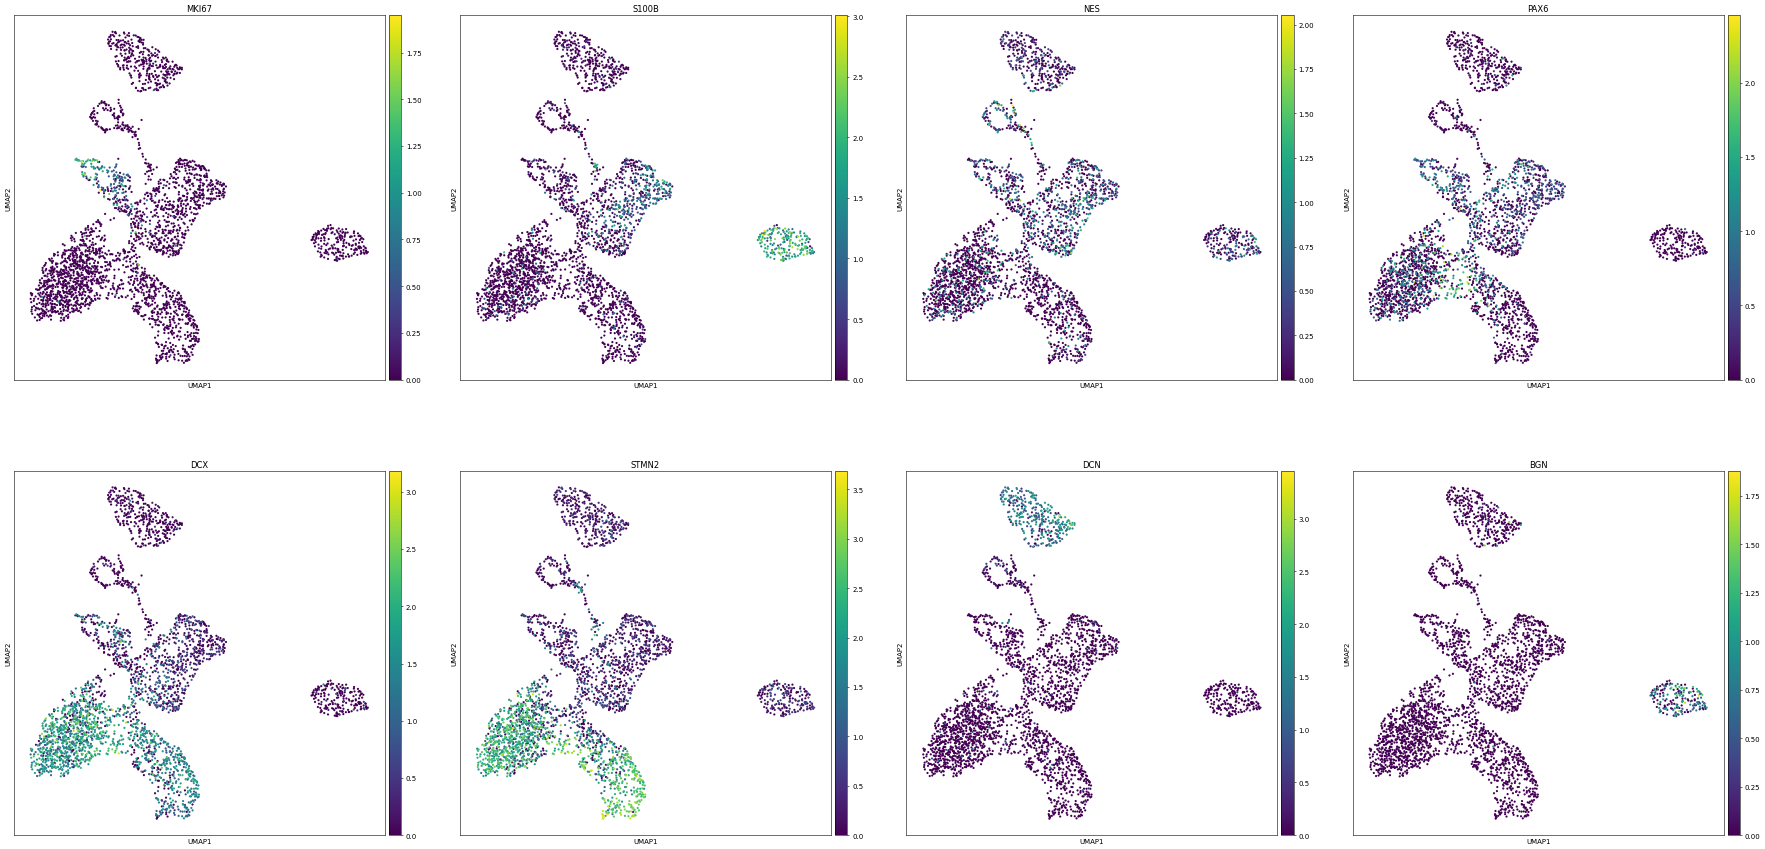

In [43]:
sc.pl.umap(scanpyObj, color=['MKI67', 'S100B',"NES","PAX6","DCX",'STMN2',"DCN", "BGN"])

In [44]:
sc.tl.diffmap(scanpyObj)


computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99931264 0.99668825 0.9957199  0.9937119  0.9929281
     0.9921038  0.9814363  0.97676903 0.9760958  0.97134644 0.9686266
     0.9669611  0.9621827  0.9587331 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [45]:
sc.tl.dpt(scanpyObj)


    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Pseudotime using n_dcs=10
    finished: added
 (0:00:00)


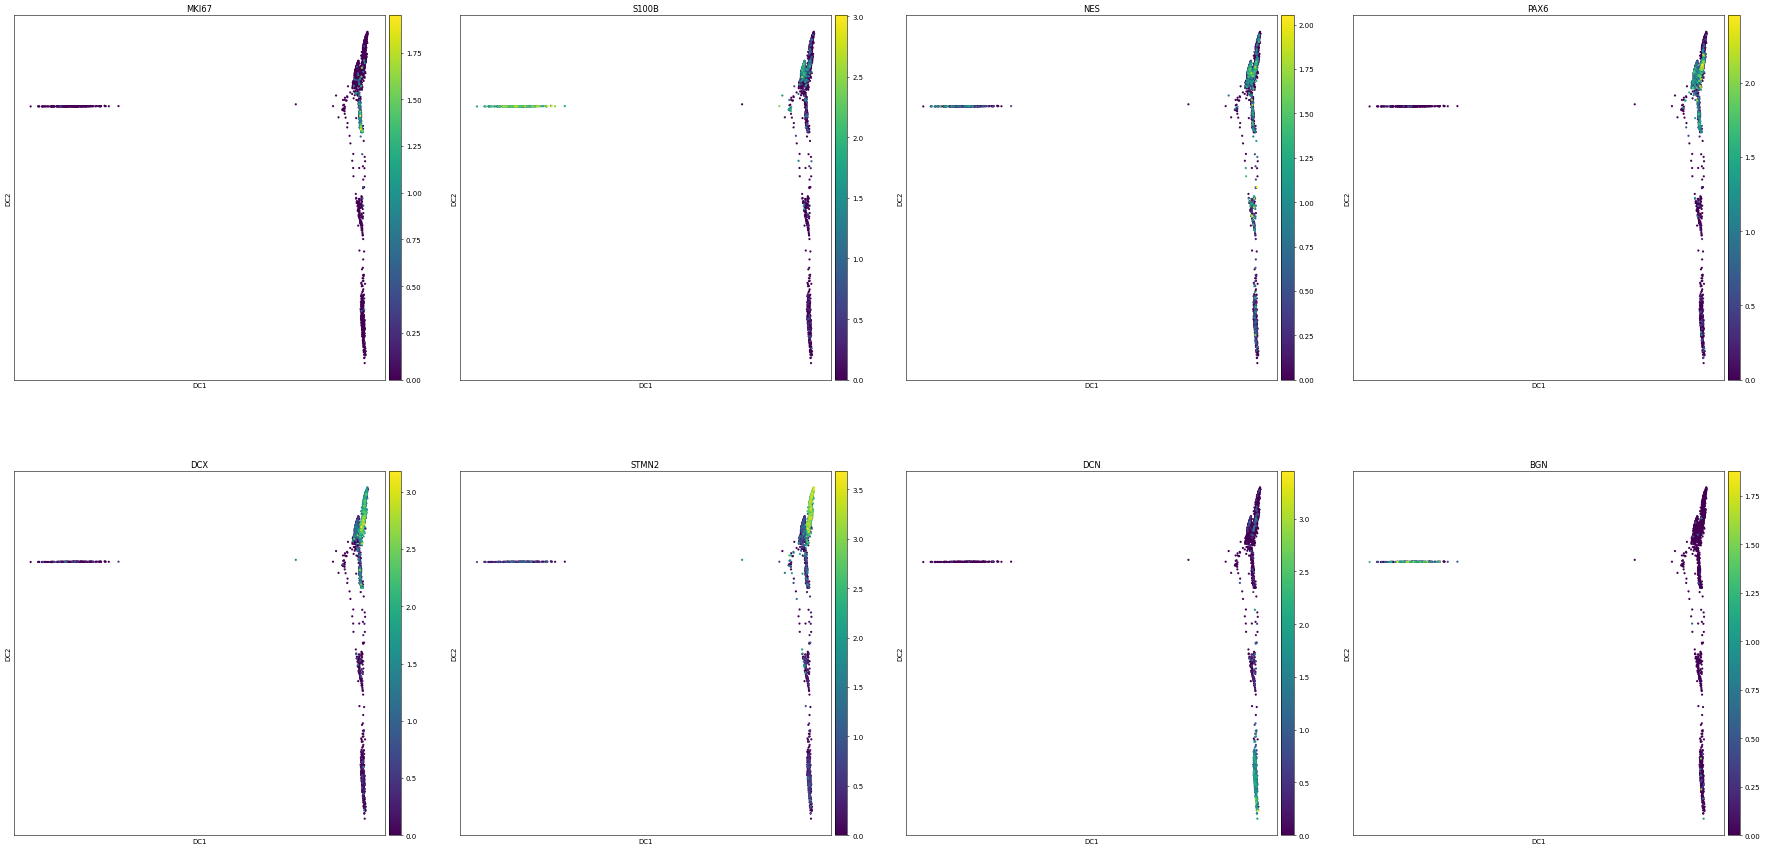

In [46]:
sc.pl.diffmap(scanpyObj, color=[ 'MKI67', 'S100B',"NES","PAX6","DCX",'STMN2',"DCN", "BGN"])


In [47]:
scanpyObj.X.max()

20.0